# Backpropagation in PyTorch: Manual vs Autograd

In [60]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

torch.manual_seed(42)

# Synthetic regression data: y = 3x + noise
N = 200
x = torch.linspace(-3, 3, N).unsqueeze(1)
y = torch.where(
    x.abs() < 1.0,
    torch.zeros_like(x),                           # flat region around 0
    torch.sin(3 * x) + 0.3 * torch.sign(x)         # oscillatory outside
)
y += 0.1 * torch.randn_like(x)                     # add small noise
# Architecture and hyperparameters
layers = [1, 16, 16, 16, 16, 1]  # 4 hidden layers
lr = 0.05
epochs = 3000

## 1. Manual Backpropagation

In [61]:
W = [torch.randn(layers[i], layers[i+1]) * 0.5 for i in range(len(layers)-1)]
b = [torch.zeros(layers[i+1]) for i in range(len(layers)-1)]

loss_history_manual = []
start_manual = time.time()

for t in range(epochs):
    # Forward pass
    h = [x]
    for i in range(len(W)-1):
        h.append(torch.tanh(h[-1] @ W[i] + b[i]))
    y_pred = h[-1] @ W[-1] + b[-1]
    loss = ((y_pred - y)**2).mean()
    loss_history_manual.append(loss.item())

    # Backward pass (manual gradients)
    grad_y_pred = 2.0 * (y_pred - y) / y.size(0)
    dW = [None] * len(W)
    db = [None] * len(b)

    # Output layer
    dW[-1] = h[-1].T @ grad_y_pred
    db[-1] = grad_y_pred.sum(0)
    delta = grad_y_pred @ W[-1].T

    # Hidden layers
    for i in reversed(range(len(W)-1)):
        delta = delta * (1 - h[i+1]**2)  # tanh'
        dW[i] = h[i].T @ delta
        db[i] = delta.sum(0)
        if i != 0:
            delta = delta @ W[i].T

    # Parameter update
    for i in range(len(W)):
        W[i] -= lr * dW[i]
        b[i] -= lr * db[i]

end_manual = time.time()
time_manual = end_manual - start_manual

## 2. PyTorch Autograd

In [62]:
model = torch.nn.Sequential(
    torch.nn.Linear(1, 16),
    torch.nn.Tanh(),
    torch.nn.Linear(16, 16),
    torch.nn.Tanh(),
    torch.nn.Linear(16, 16),
    torch.nn.Tanh(),
    torch.nn.Linear(16, 16),
    torch.nn.Tanh(),
    torch.nn.Linear(16, 1)
)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_history_auto = []

start_auto = time.time()

for t in range(epochs):
    y_pred = model(x)
    loss = F.mse_loss(y_pred, y)
    loss_history_auto.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

end_auto = time.time()
time_auto = end_auto - start_auto

## 3. Comparison and Visualisation

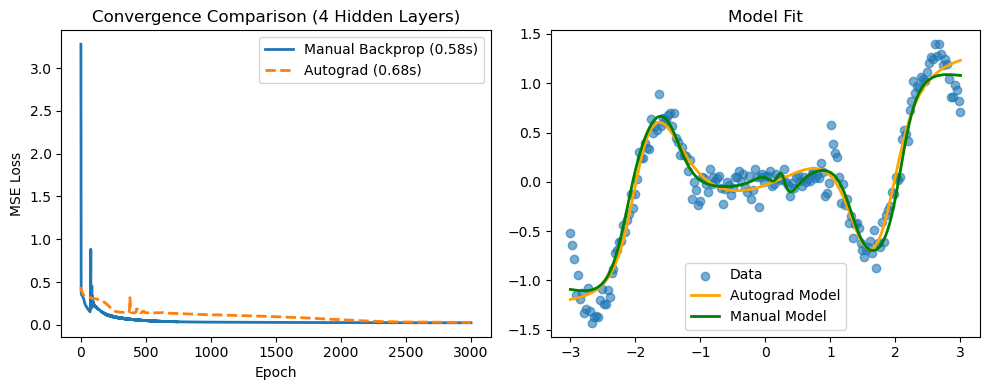

In [63]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(loss_history_manual, label=f"Manual Backprop ({time_manual:.2f}s)", lw=2)
plt.plot(loss_history_auto, label=f"Autograd ({time_auto:.2f}s)", lw=2, ls="--")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Convergence Comparison (4 Hidden Layers)")
plt.legend()

plt.subplot(1, 2, 2)
with torch.no_grad():
    plt.scatter(x, y, label="Data", alpha=0.6)
    plt.plot(x, model(x), label="Autograd Model", color='orange', lw=2)
    # Manual model forward pass for plotting
    h_plot = x
    for i in range(len(W)-1):
        h_plot = torch.tanh(h_plot @ W[i] + b[i])
    y_plot = h_plot @ W[-1] + b[-1]
    plt.plot(x, y_plot, label="Manual Model", color='green', lw=2)
plt.title("Model Fit")
plt.legend()
plt.tight_layout()
plt.show()


## 4. Timing and Performance Summary

In [64]:
print(f"Manual Backprop time: {time_manual:.3f} s")
print(f"Autograd time:        {time_auto:.3f} s")
print(f"Speed-up (manual/autograd): {time_manual / time_auto:.2f}x")

# Compute final training errors
with torch.no_grad():
    # Manual network
    h_eval = x
    for i in range(len(W)-1):
        h_eval = torch.tanh(h_eval @ W[i] + b[i])
    y_manual = h_eval @ W[-1] + b[-1]
    err_manual = F.mse_loss(y_manual, y).item()

    # Autograd network
    y_auto = model(x)
    err_auto = F.mse_loss(y_auto, y).item()

print(f"Final Training MSE (manual):   {err_manual:.6f}")
print(f"Final Training MSE (autograd): {err_auto:.6f}")
print(f"MSE ratio (manual/autograd):   {err_manual / err_auto:.3f}x")

Manual Backprop time: 0.578 s
Autograd time:        0.684 s
Speed-up (manual/autograd): 0.85x
Final Training MSE (manual):   0.023311
Final Training MSE (autograd): 0.026683
MSE ratio (manual/autograd):   0.874x
